# RNA-Seq data analysis using edgeR
##### Justin Huberts, Jeffrey Hiraki & Jonathan Feenstra

# Introduction

In [747]:
import rpy2
from rpy2.robjects.packages import importr

base = importr('base')
utils = importr('utils')
graphics = importr('graphics')
stats    = importr('stats')
grdevices = importr('grDevices')
from rpy2.robjects.lib import grdevices
lattice = importr('lattice')
ggplot2 = importr('ggplot2')
limma = importr('limma')
edger = importr('edgeR')
dplyr = importr('dplyr')
tidyr = importr('tidyr')
tibble = importr('tibble')
fgsea = importr('fgsea')
ggfortify = importr('ggfortify')
ggrepel = importr('ggrepel')
rtracklayer = importr('rtracklayer')
GenomicRanges = importr('GenomicRanges')
factoextra = importr('factoextra')


import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import FloatVector as c
from rpy2.robjects.vectors import DataFrame
from rpy2.robjects import globalenv as var 
rprint = robjects.globalenv.get("print")

r = robjects.r

from IPython.display import Image, display

print(rpy2.__version__)
print(r('.libPaths()')[0])

2.8.6
D:/Users/Emperor Justinian/Anaconda/envs/tensorflowprojects/R/library


In [748]:
def render(x=None, y=None, width=1024, height=896, res=150, col='green', main='Scatterplot', xlab='', ylab='', pch=19, data='', colour='', plot='plot'):

    with grdevices.render_to_bytesio(grdevices.png, 
                                     width=width,
                                     height=height, 
                                     res=res) as img:
        rcommand = str('{0}').format(str(x))
        if plot == 'plot':
            graphics.plot(x, y, col=col, main=main, xlab=xlab, ylab=ylab, pch=pch)
        if plot == 'box':
            r('par(cex.axis=0.4)')
            graphics.boxplot(x, col=col, main=main, xlab=xlab, ylab=ylab, pch=pch, las=2)
        if plot == 'bar':
            r('par(cex.axis=0.4)')
            graphics.barplot(x, col=col, main=main, xlab=xlab, ylab=ylab, pch=pch, las=2)
        if plot == 'biplot':
            stats.biplot(x, main='Biplot')
        if plot == 'varplot':
            graphics.plot(r('fviz_eig(' + rcommand + ')'))
        if plot == 'hclust':
            graphics.plot(r('hclust(dist(t(' + rcommand + ')), method="ward.D2")')) # eu werd vervangen door ward.D2
        if plot == 'prcomp':
            r('pr <- prcomp(' + rcommand + ', centre=TRUE, scale.=TRUE)')
            r('plot(pr, main="Variance")')
        if plot == 'plotMDS':
            r('plotMDS(' + rcommand + ', main="plotMDS")')
        if plot == 'plotMeanVar':
            r("plotMeanVar(" + rcommand + ", main='plotMeanVar')")
        if plot == 'plotBCV':
            r("plotBCV(" + rcommand + ", main='plotBCV')")
        if plot == 'plotSmear':
            r("plotSmear(" + rcommand + ", de.tags=Genes, main='plotSmear')")
            graphics.abline(h=r('c(-1, 1)'), col=2)
        if plot == 'auto':
            r("print(autoplot(" + rcommand + ", data=" + data + ", colour=" + colour + ", main='PCA'))")
   
    display(Image(data=img.getvalue(), format='png', embed=True))

In [749]:
r('fDir <- "/Users/Emperor Justinian/Jupyter Notebooks/Bio-Inf R/"');
print(r('fDir')[0])

/Users/Emperor Justinian/Jupyter Notebooks/Bio-Inf R/


# Loading the count vectors

In [750]:
r('files <- list.files(path = fDir, pattern = "Counts.csv$")')

r('DF <-  read.csv(files[1])') # Indeces starten met 1 in R...
r('for (f in files[-1]) DF <- cbind(DF, read.csv(paste0(fDir, f), header=TRUE, sep="\t"))') # Concat de dfs
r('colnames(DF) <- c("SRR8987669","SRR8987671", "count1", "SRR8987673", "count2", "SRR8987684", "count3", "SRR8987685", "count4", "SRR8987686", "count5")')
r('DF <- separate(data = DF, col = "SRR8987669", into = c("SRR8987669", "count0"), sep = "\\t")') # Split de eerste kolom op tabs

r('DF$dup = gsub("gene:", "", DF$SRR8987686)')
r('DF <- head(data.frame(column_to_rownames(DF, var = "dup")), -5)')

r('DF <- DF[,-c(3,5,7,9,11)]') # Verwijdert deze kolommen
r('colnames(DF) <- c("Genes","SRR8987669","SRR8987671","SRR8987673","SRR8987684","SRR8987685","SRR8987686")') # ReIntroduceert de namen
r('DF <- transform(DF, SRR8987669 = as.numeric(SRR8987669))') # maakt ints van deze kolom
r('DF <- DF[,-c(1)]') # Verwijderd deze kolom
r('m <- data.matrix(DF)') # Dataframe naar matrix

print(r('head(m)'))

                   SRR8987669 SRR8987671 SRR8987673 SRR8987684 SRR8987685

chrIII_pilon.g6685          0          0          0          0         66

chrIII_pilon.g6686          0          0          1          0         14

chrIII_pilon.g6687          3          1          1          1        268

chrIII_pilon.g6688          0          0          2          0        129

chrIII_pilon.g6689          0          0          1          0         68

chrIII_pilon.g6690          0          0          0          1        204

                   SRR8987686

chrIII_pilon.g6685          0

chrIII_pilon.g6686          0

chrIII_pilon.g6687          1

chrIII_pilon.g6688          0

chrIII_pilon.g6689          0

chrIII_pilon.g6690          0



In [751]:
print(r('summary(m)'))

   SRR8987669         SRR8987671         SRR8987673          SRR8987684      

 Min.   :   0.000   Min.   :   0.000   Min.   :    0.000   Min.   :   0.000  

 1st Qu.:   0.000   1st Qu.:   0.000   1st Qu.:    0.000   1st Qu.:   0.000  

 Median :   0.000   Median :   0.000   Median :    0.000   Median :   0.000  

 Mean   :   5.233   Mean   :   4.456   Mean   :    4.523   Mean   :   4.708  

 3rd Qu.:   2.000   3rd Qu.:   1.000   3rd Qu.:    1.000   3rd Qu.:   1.000  

 Max.   :6815.000   Max.   :9134.000   Max.   :11918.000   Max.   :5784.000  

   SRR8987685       SRR8987686      

 Min.   :     0   Min.   :   0.000  

 1st Qu.:     4   1st Qu.:   0.000  

 Median :    87   Median :   0.000  

 Mean   :  1431   Mean   :   4.453  

 3rd Qu.:  1112   3rd Qu.:   1.000  

 Max.   :436665   Max.   :5462.000  



# EdgeR: normalization

In [752]:
r('pdf(paste0(fDir,"res.pdf"),width=10,height=10)');

In [753]:
r('group <- factor(c(1,1,1,2,2,2))')
r('countlist <- DGEList(counts=m, group=group)')
r('keep <- filterByExpr(countlist, group=group)') 
r('countlist <- countlist[keep, keep.lib.sizes=FALSE]')
r('countlist <- calcNormFactors(countlist, method="TMM")'); # Possibly add Yuen's t-test

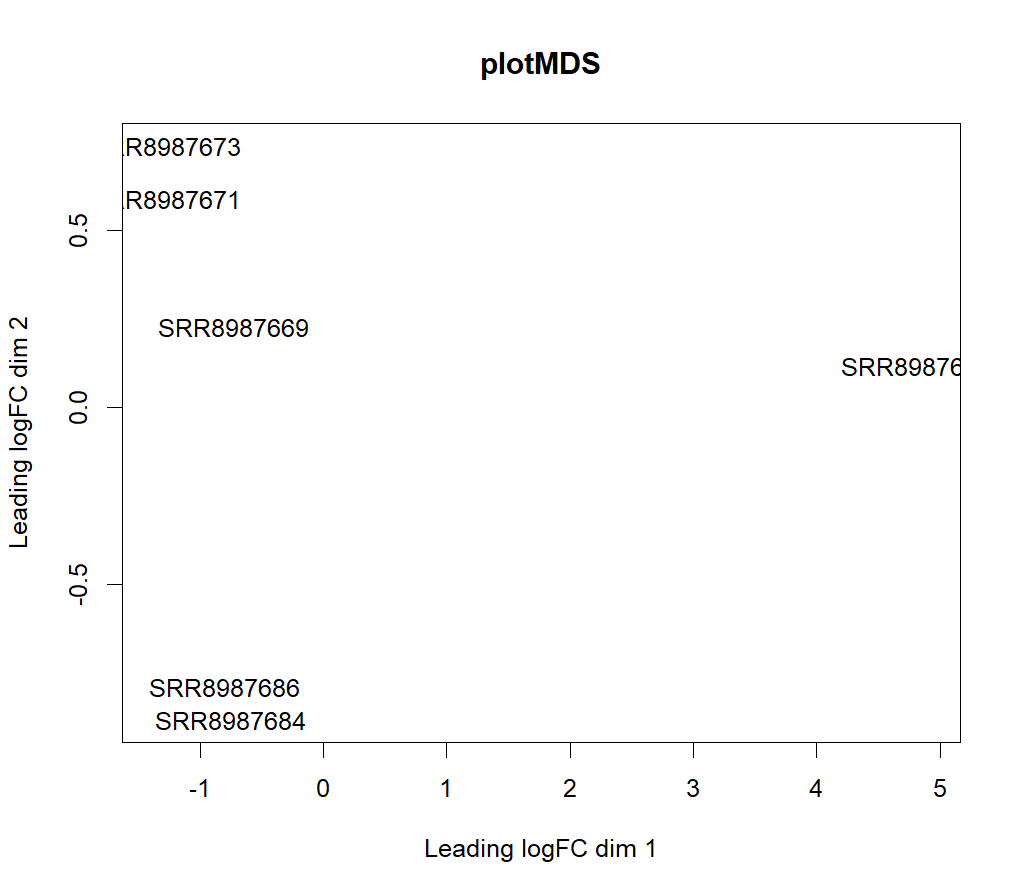

In [754]:
render('countlist', main='mds', plot='plotMDS')

# Estimate parameters

In [755]:
r('design <- model.matrix(~group)')
r('GLMcomdisp <- estimateGLMCommonDisp(countlist, design)')
r('GLMtrenddisp <- estimateGLMTrendedDisp(countlist, design)')
r('GLMtagdisp <- estimateGLMTagwiseDisp(GLMcomdisp, design)')
r('countlist <- estimateDisp(countlist)');

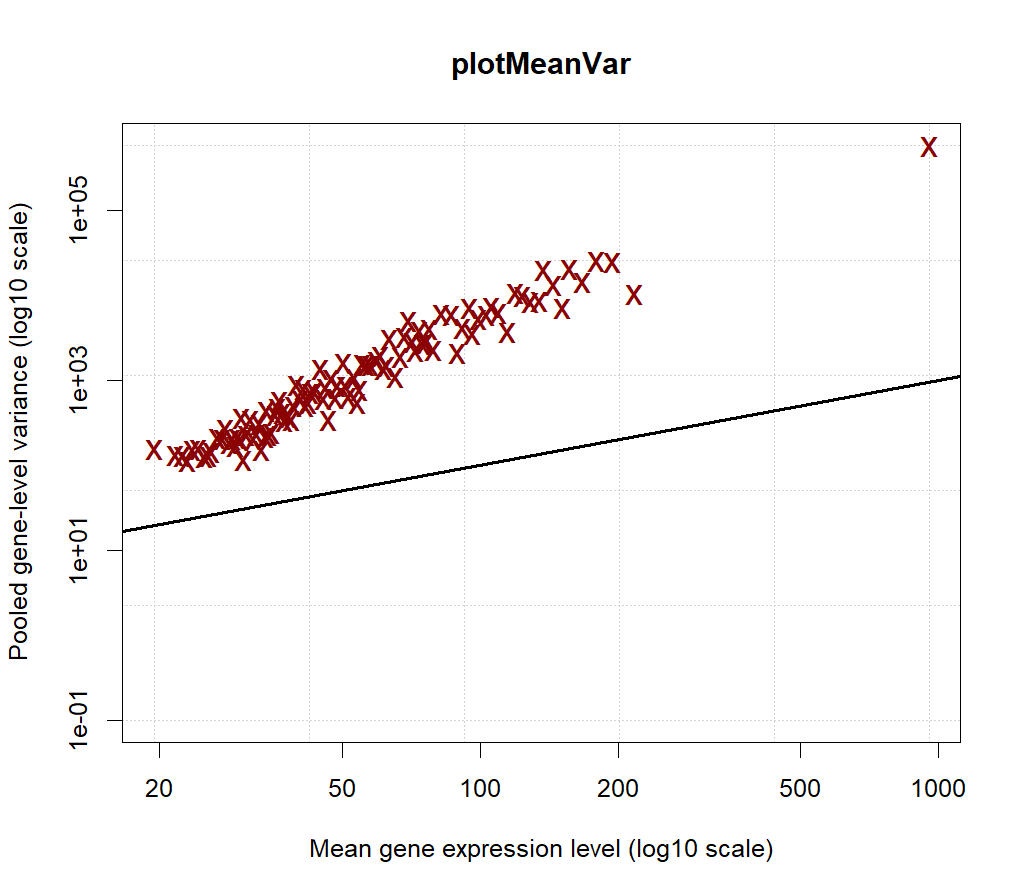

In [756]:
render('GLMcomdisp', main='mean var', plot='plotMeanVar')

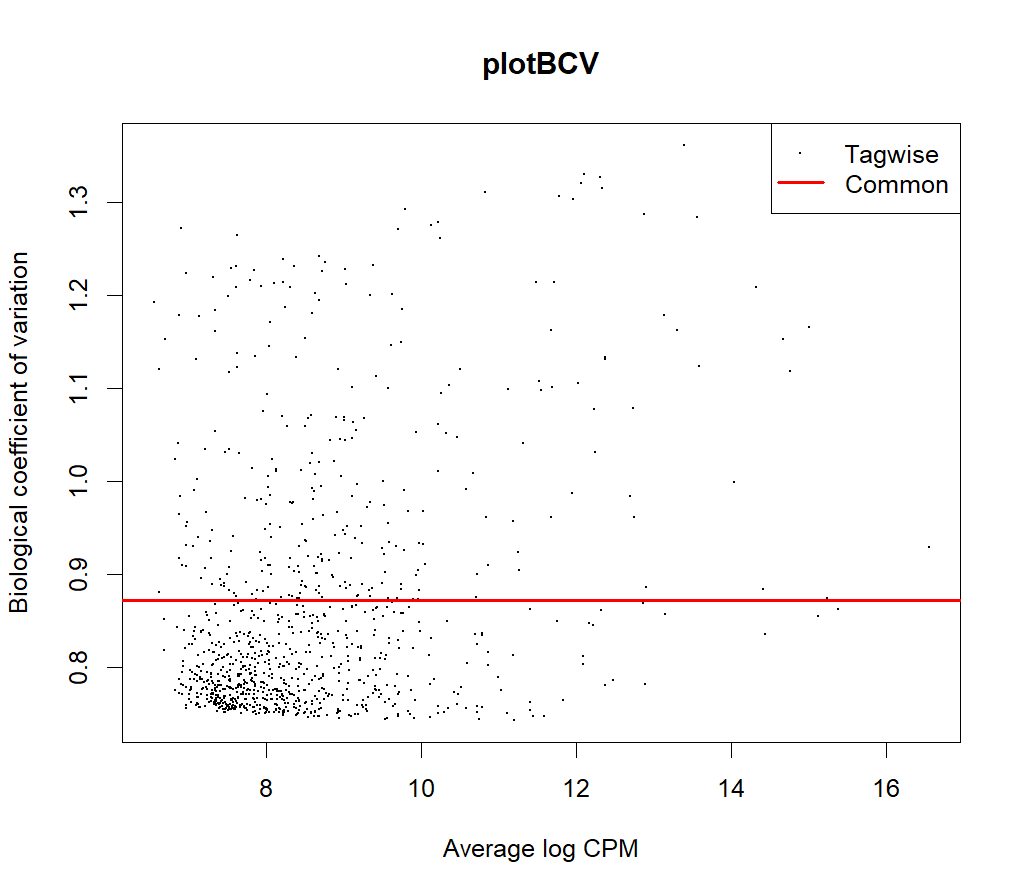

In [757]:
render('GLMtagdisp', main='BCV', plot='plotBCV')

# GLM fit

In [758]:
r('fit <- glmFit(countlist,design)')
r('lrt <- glmLRT(fit,coef=2)')
r('edgeR_result <- topTags(lrt)')
print(r('edgeR_result'))

Coefficient:  group2 

                        logFC   logCPM       LR       PValue          FDR

chrV_pilon.g15706  -12.547058 8.041343 73.24355 1.145992e-17 1.133386e-14

chrV_pilon.g13115   12.677560 7.025440 40.14707 2.355443e-10 1.164767e-07

chrIV_pilon.g11602  -5.021519 7.297237 38.21756 6.328042e-10 2.086144e-07

chrV_pilon.g17544   13.562415 7.900813 31.18491 2.345827e-08 5.800058e-06

chrV_pilon.g16360    4.516230 7.455272 23.58579 1.194663e-06 2.363043e-04

chrV_pilon.g16203   -3.270701 8.412310 20.36491 6.399263e-06 1.054812e-03

chrV_pilon.g13877    4.699850 7.644071 19.77010 8.733840e-06 1.233967e-03

chrX_pilon.g19434    6.154133 7.550629 18.24719 1.940116e-05 2.398468e-03

chrV_pilon.g16034    2.775767 8.323171 15.19639 9.688829e-05 1.064695e-02

chrII_pilon.g4885   -2.146968 7.538045 14.78862 1.202589e-04 1.189360e-02



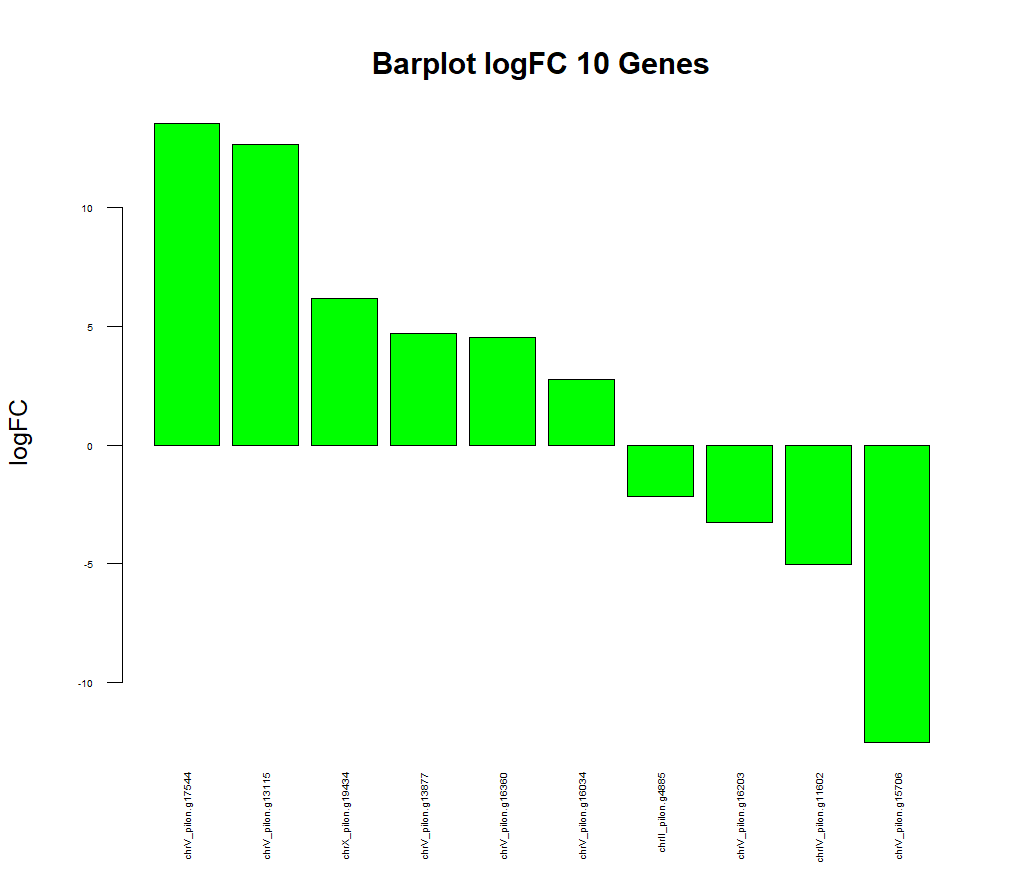

In [759]:
r('edgeR_result <- data.frame(edgeR_result)');
r('ranks <- edgeR_result$logFC')
r('names(ranks) <- rownames(edgeR_result)')
render(r('sort(ranks, decreasing = T)'), xlab='', ylab='logFC', main='Barplot logFC 10 Genes', plot='bar')

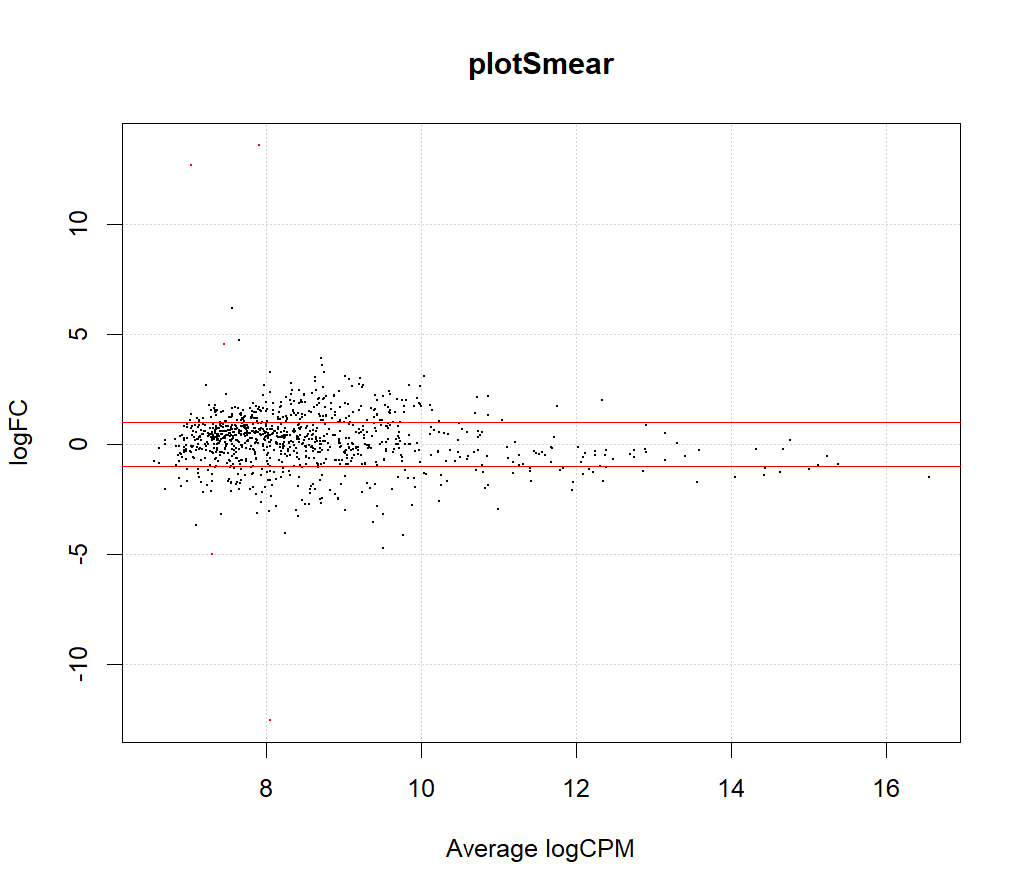

In [760]:
r('Genes <- decideTestsDGE(lrt, p=0.001)')
r('Genes <- rownames(lrt)[as.logical(Genes)]')

render('lrt', main='plotSmear', plot='plotSmear')

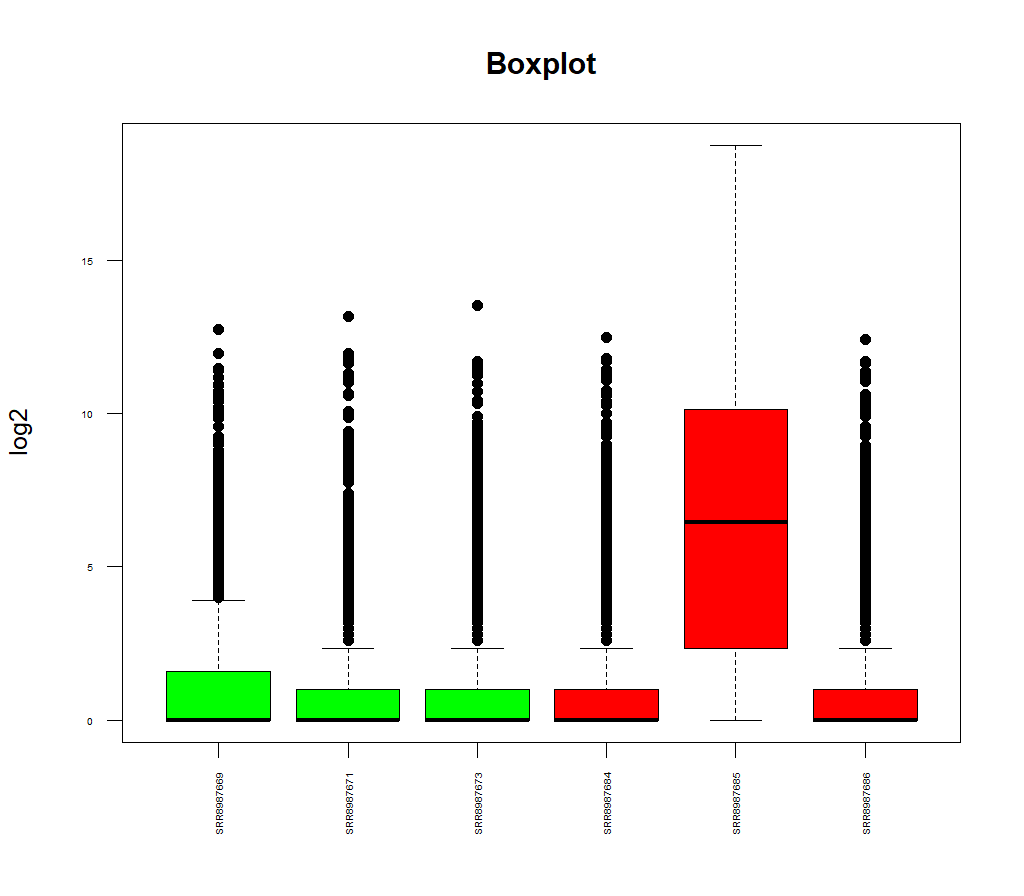

In [761]:
r('lm <- log2(m+1)')

r('lm <- na.omit(lm)')
r('m <- na.omit(m)')

r('pdf(paste0(fDir,"res.pdf"),width=10,height=10)')

r('colors <- c("green", "green", "green", "red", "red", "red")')

render(r('lm'), main='Boxplot', xlab='', ylab='log2', col=r('colors'), plot='box')

### SRR8987685 appears to be an outlier, so it will be removed. The other five appear to be similar. 

# Clustering & PCA

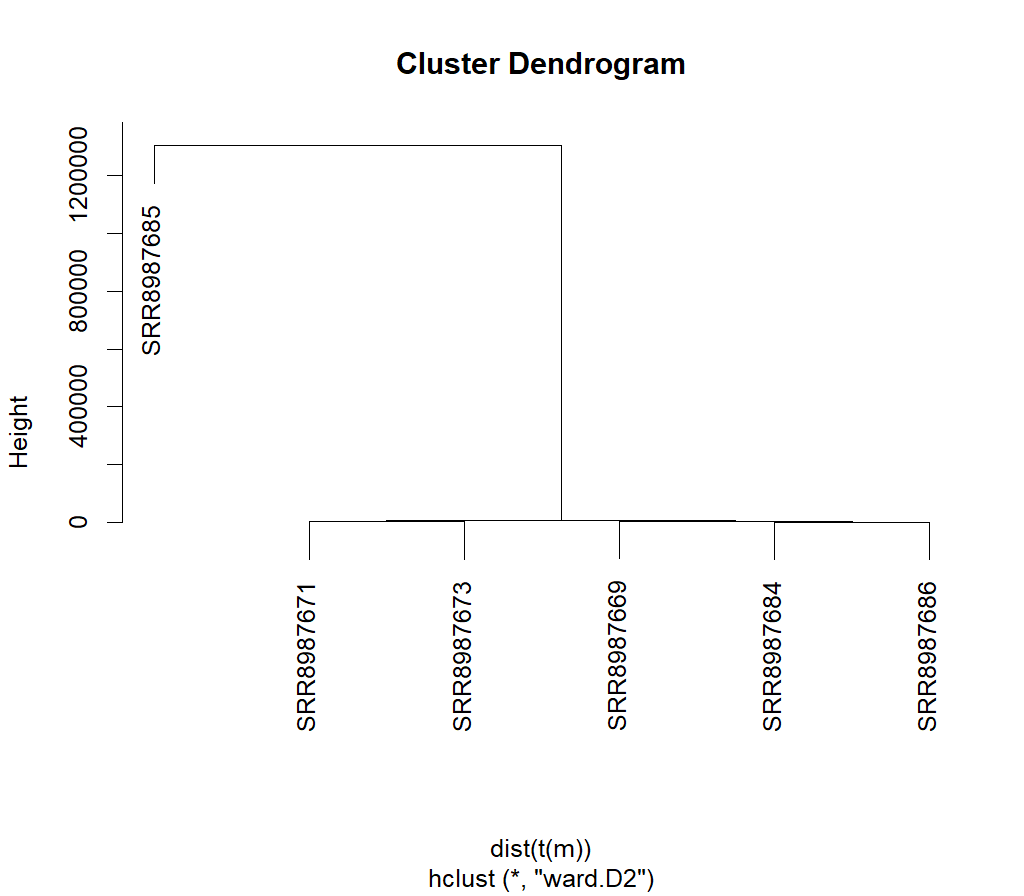

In [762]:
render('m', plot='hclust')

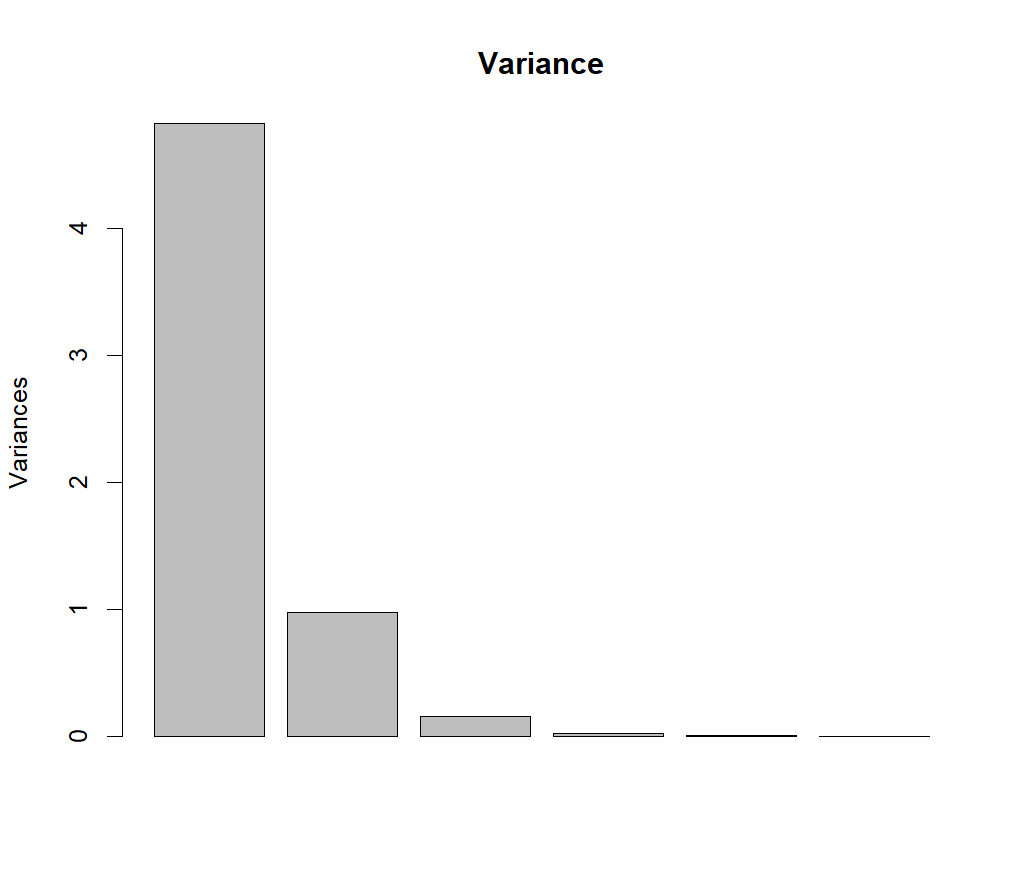

In [763]:
render('m', plot='prcomp')

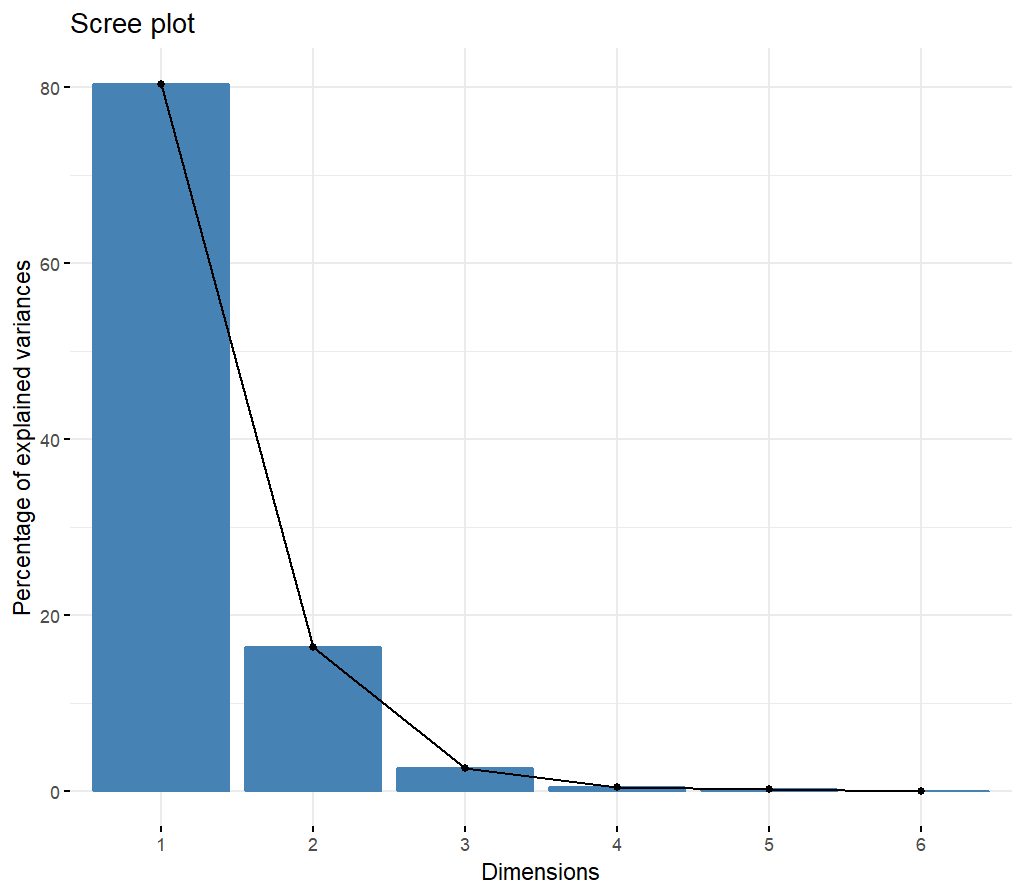

In [764]:
render('pr', plot='varplot')

In [765]:
print(r('summary(pr)'))

Importance of components:

                          PC1    PC2    PC3    PC4     PC5     PC6

Standard deviation     2.1968 0.9898 0.3957 0.1606 0.10623 0.02826

Proportion of Variance 0.8043 0.1633 0.0261 0.0043 0.00188 0.00013

Cumulative Proportion  0.8043 0.9676 0.9937 0.9980 0.99987 1.00000



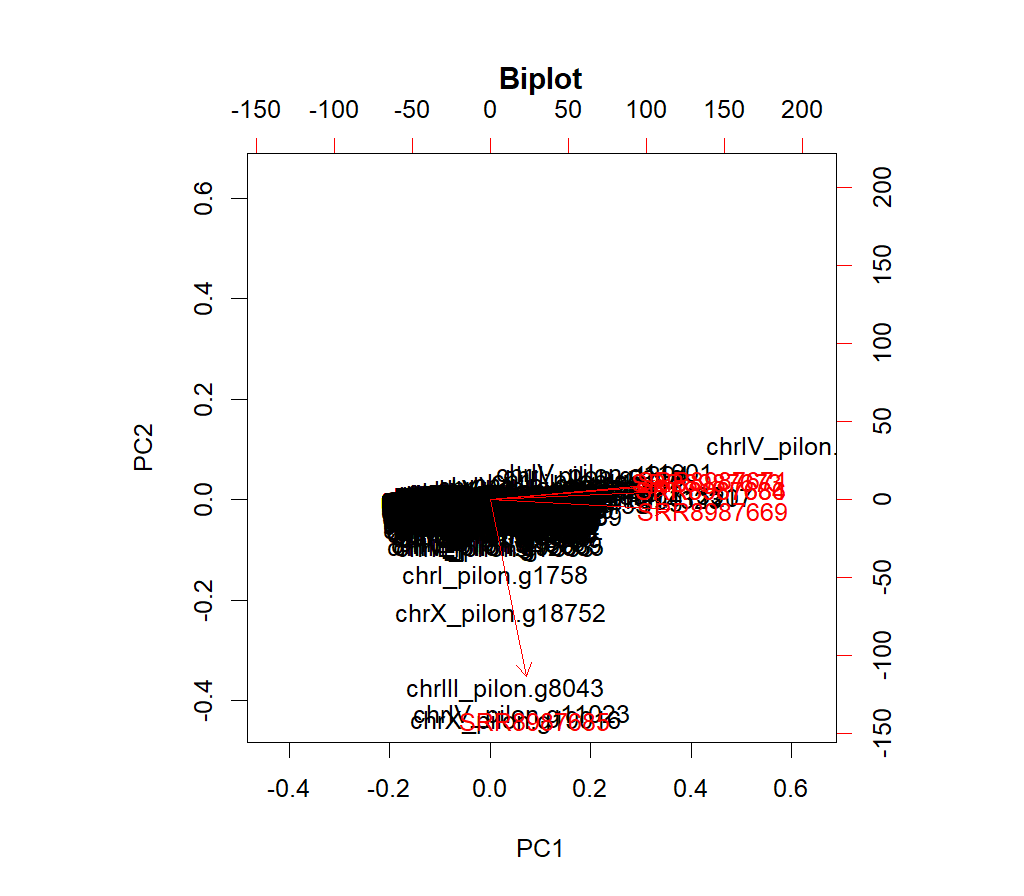

In [766]:
render(r('pr'), plot='biplot')
r('dev.off()'); # De ; is belangrijk zodat hij geen extra output cell geeft

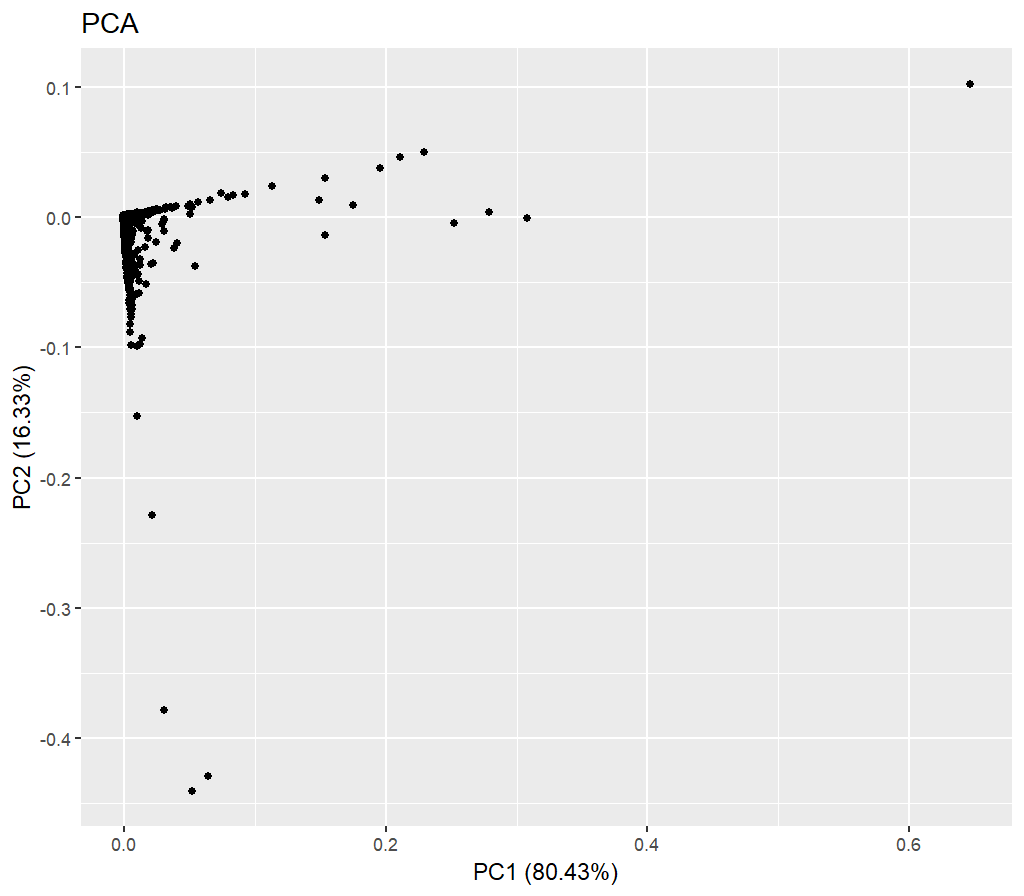

In [767]:
render('pr', plot='auto', data='m')

# The next part is without the outlier SRR8987685

# EdgeR: normalization

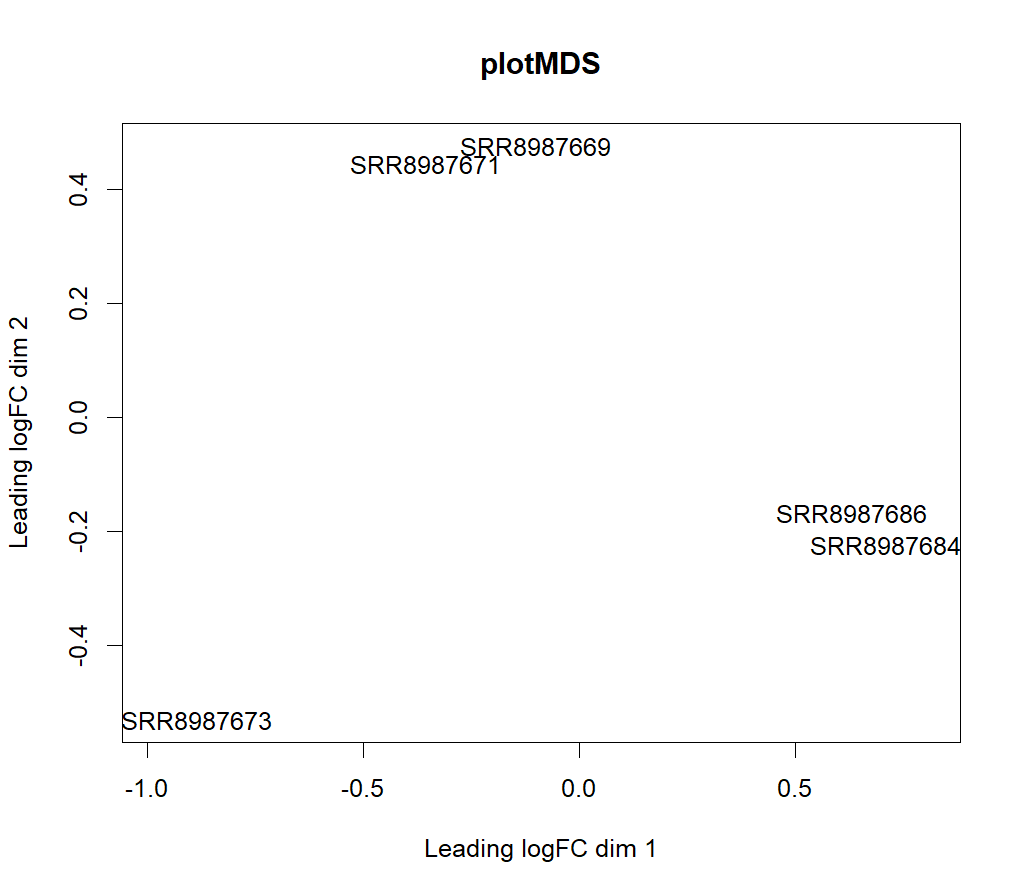

In [768]:
r('m <- m[,c("SRR8987669","SRR8987671","SRR8987673","SRR8987684","SRR8987686")]')
r('group <- factor(c(1,1,1,2,2))')
r('countlist <- DGEList(counts=m, group=group)')
r('keep <- filterByExpr(countlist)') 
r('countlist <- countlist[keep, keep.lib.sizes=FALSE]')
r('countlist <- calcNormFactors(countlist, method="TMM")') # Possibly add Yuen's t-test

render('countlist', main='mds', plot='plotMDS')

# Estimate parameters

In [769]:
r('design <- model.matrix(~group)')
r('GLMcomdisp <- estimateGLMCommonDisp(countlist, design)')
r('GLMtrenddisp <- estimateGLMTrendedDisp(countlist, design)')
r('GLMtagdisp <- estimateGLMTagwiseDisp(GLMcomdisp, design)')
r('countlist <- estimateDisp(countlist)');

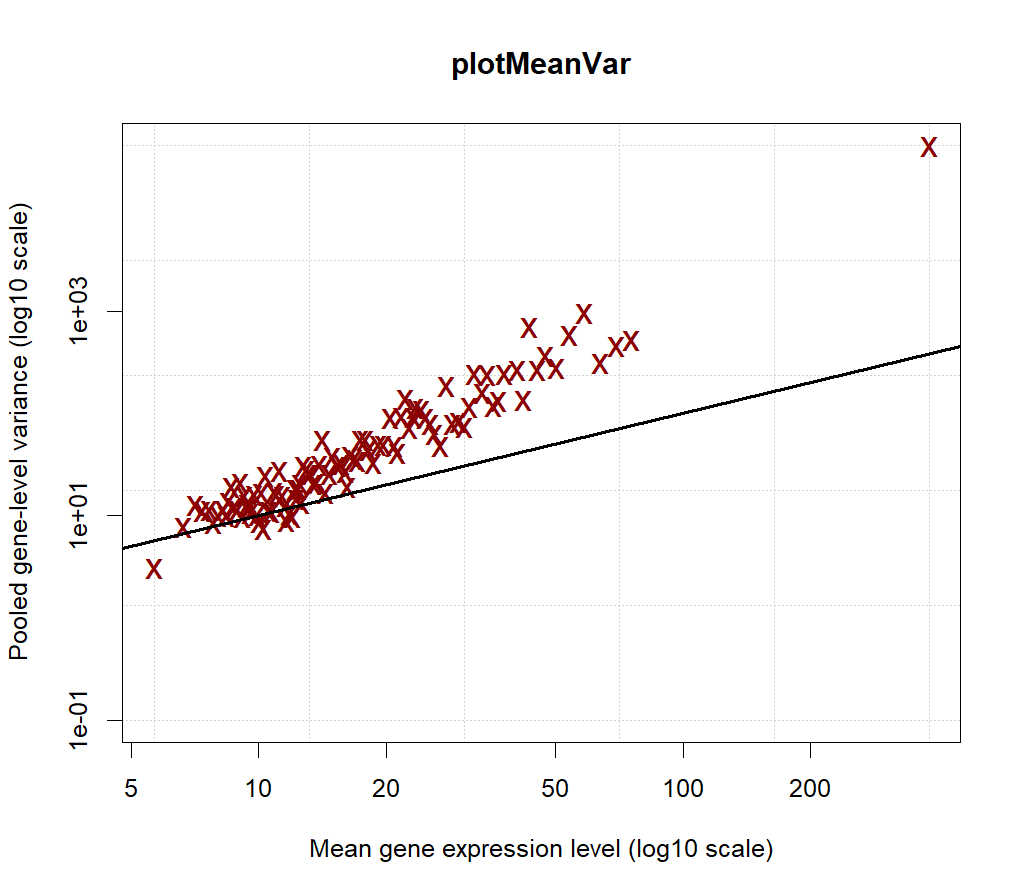

In [770]:
render('GLMcomdisp', main='mean var', plot='plotMeanVar')

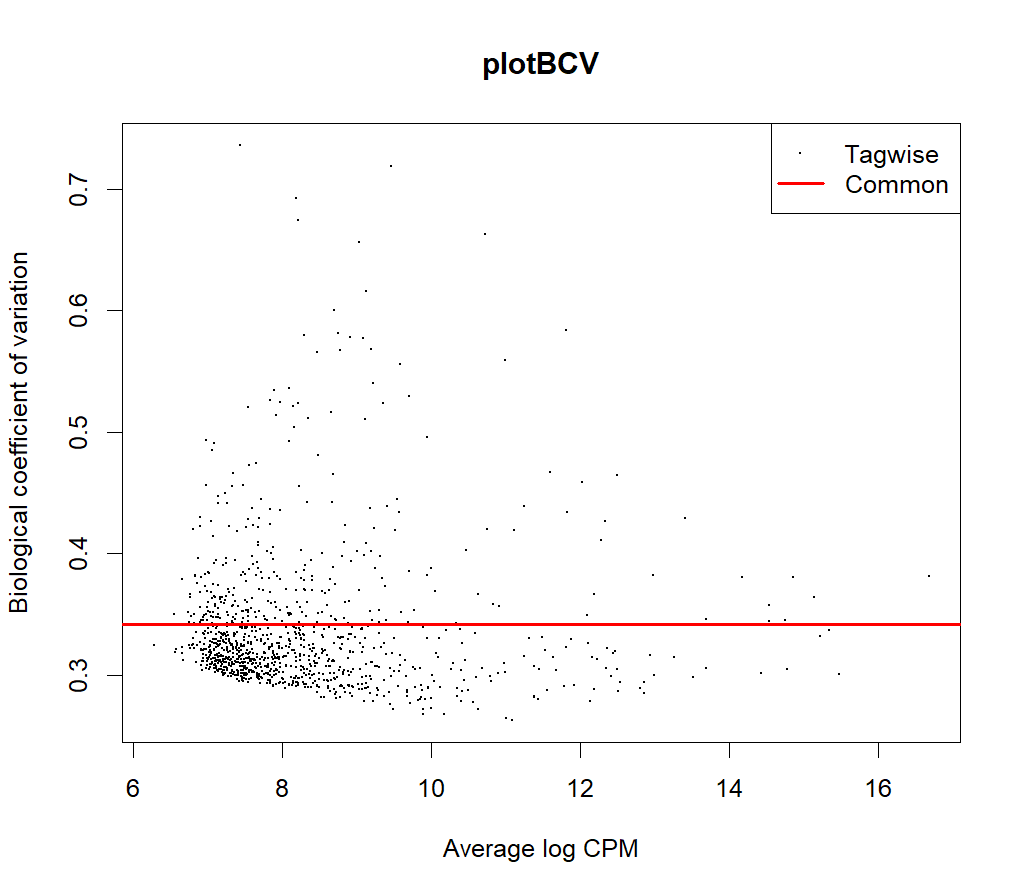

In [771]:
render('GLMtagdisp', main='BCV', plot='plotBCV')

# GLM fit

In [772]:
r('fit <- glmFit(countlist,design)')
r('lrt <- glmLRT(fit,coef=2)')
r('edgeR_result <- topTags(lrt)')
r('edgeR_result <- data.frame(Genes = rownames(edgeR_result), edgeR_result)') # Allemaal om een header te krijgen voor Genes
r('rownames(edgeR_result) <- c()')
print(r('edgeR_result'))

                Genes     logFC    logCPM       LR       PValue          FDR

1   chrV_pilon.g16673  4.754569  7.939071 53.22853 2.969154e-13 3.263101e-10

2   chrII_pilon.g3608  7.218591  6.891710 49.67410 1.815262e-12 8.443403e-10

3   chrV_pilon.g15706 -8.340687  8.287202 49.20566 2.304842e-12 8.443403e-10

4   chrV_pilon.g17544  7.068881  6.774912 46.00461 1.179751e-11 3.241366e-09

5   chrV_pilon.g13115  7.116890  6.811707 44.53331 2.500660e-11 5.496450e-09

6  chrIV_pilon.g11115  3.789193  8.108850 40.33045 2.144407e-10 3.927839e-08

7  chrIII_pilon.g8335 -4.122173  9.685653 39.36457 3.516189e-10 5.520416e-08

8   chrX_pilon.g20430  3.509565  8.044993 36.09405 1.880203e-09 2.582928e-07

9   chrV_pilon.g17896 -4.763687  7.116161 32.45702 1.218582e-08 1.488023e-06

10  chrV_pilon.g16233  2.603129 10.794572 30.51284 3.316645e-08 3.644993e-06



In [773]:
r("write.csv(as.data.frame(edgeR_result[c('Genes', 'FDR')]), file='siggenes.csv', row.names = TRUE)");

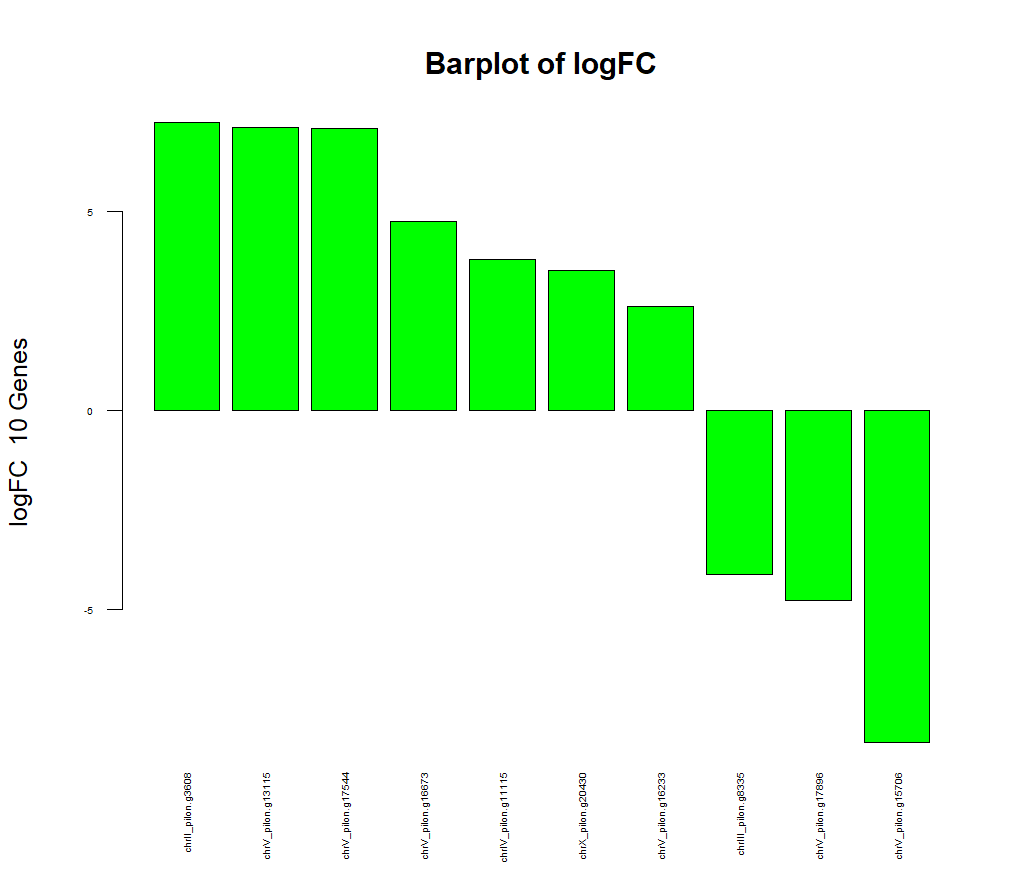

In [774]:
r('ranks <- edgeR_result$logFC')
r('names(ranks) <- edgeR_result$Genes')
render(r('sort(ranks, decreasing = T)'), main='Barplot of logFC', xlab='', ylab='logFC  10 Genes', plot='bar')

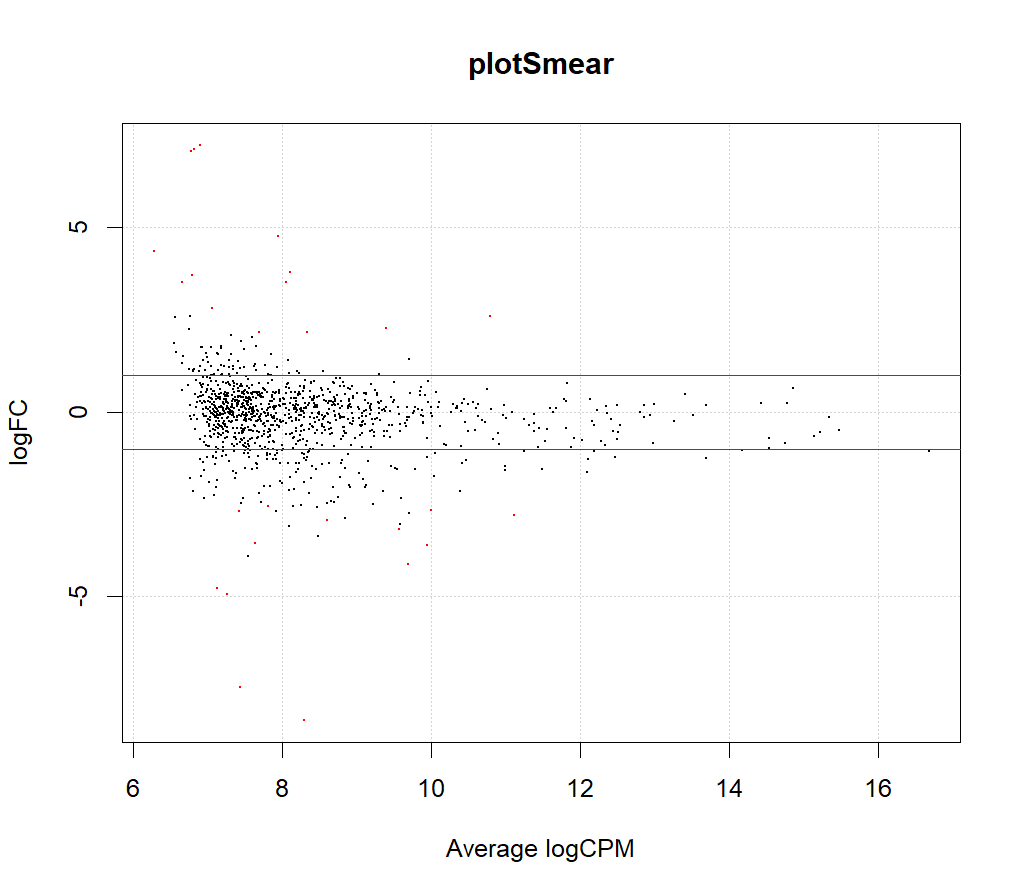

In [775]:
r('Genes <- decideTestsDGE(lrt, p=0.001)')
r('Genes <- rownames(lrt)[as.logical(Genes)]')
render('lrt', main='plotSmear', plot='plotSmear')

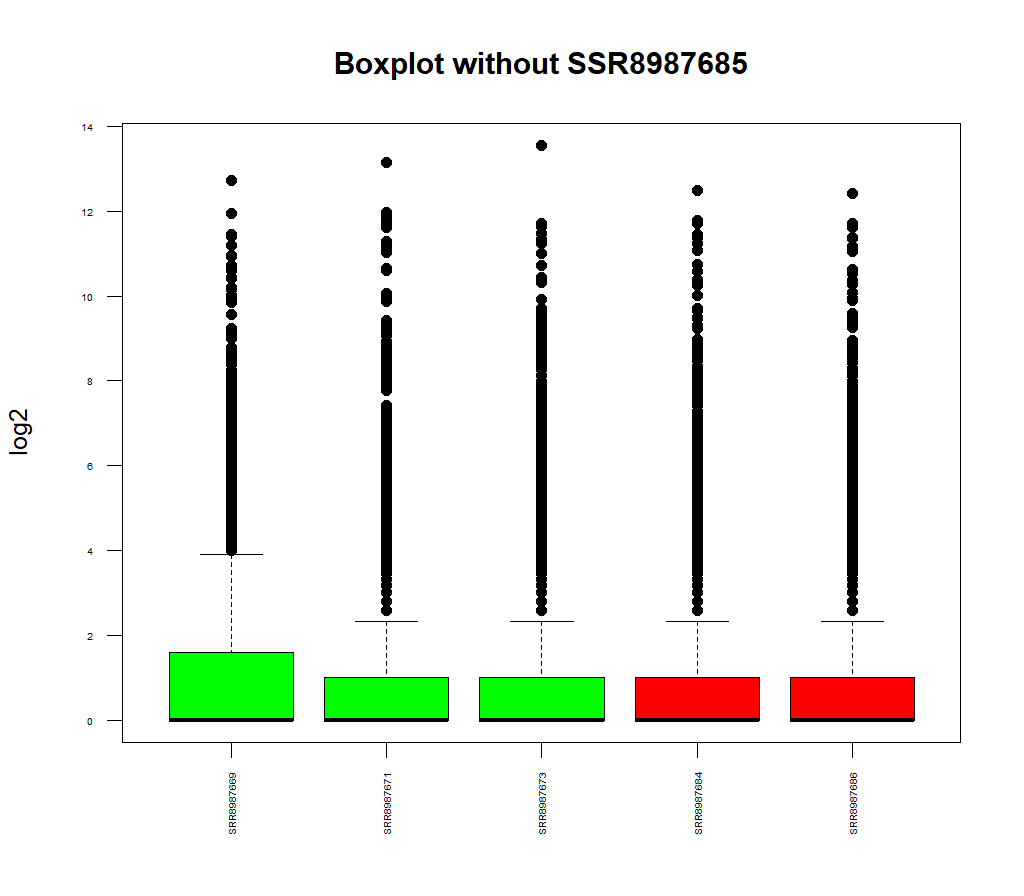

In [776]:
r('lm <- log2(m +1)')

r('lm <- na.omit(lm)')
r('m <- na.omit(m)')

r('colors <- c("green", "green", "green", "red", "red")')
    
render(r('lm'), main='Boxplot without SSR8987685', xlab='', col=r('colors'), ylab='log2', plot='box')

# Clustering & PCA

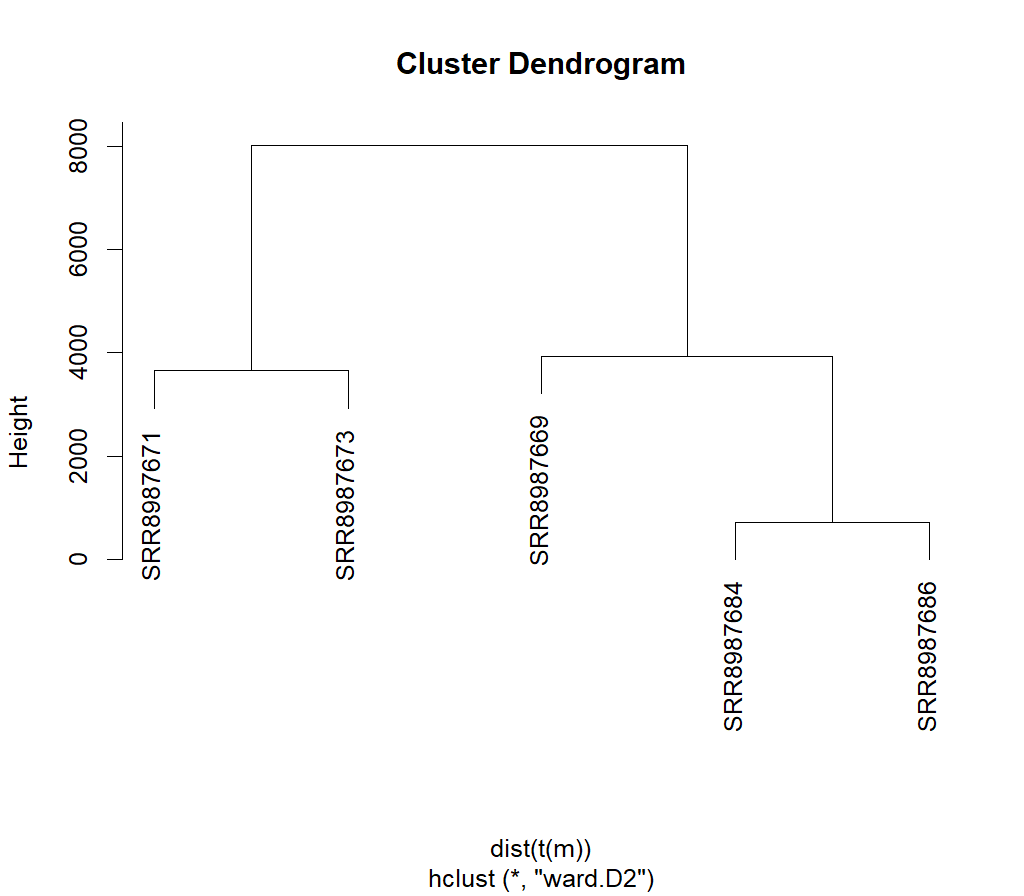

In [777]:
render('m', plot='hclust')

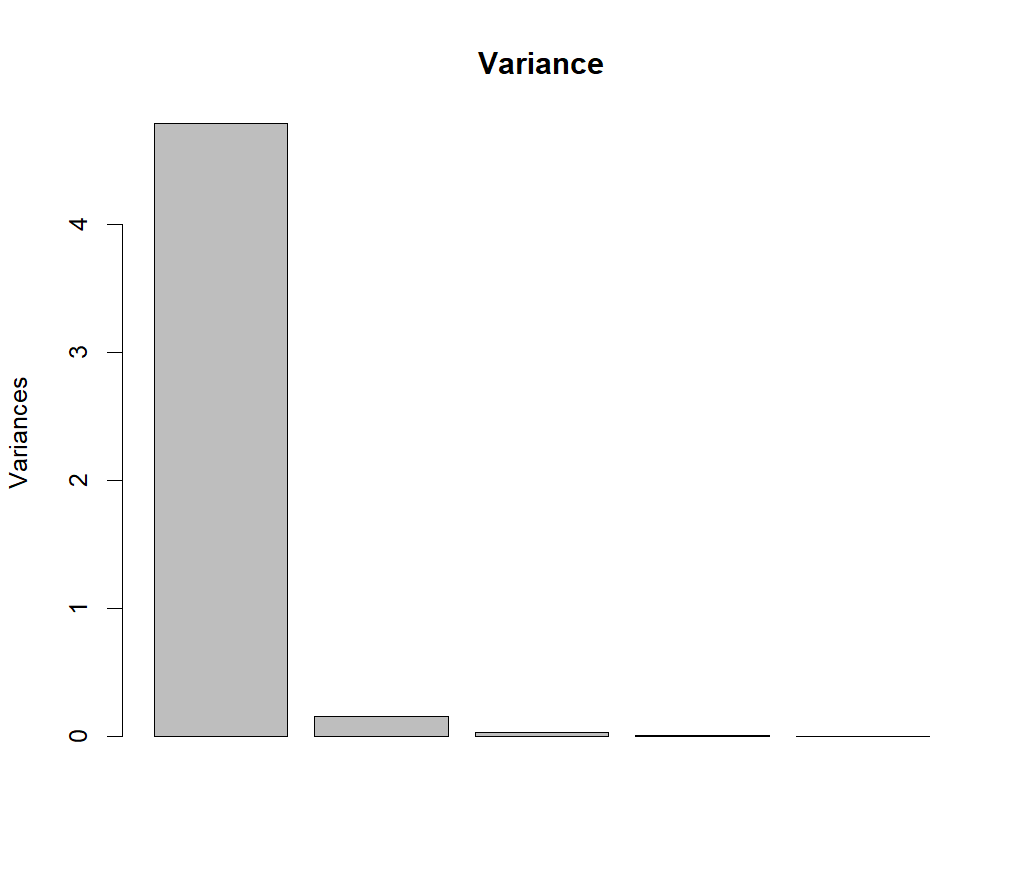

In [778]:
render('m', plot='prcomp')

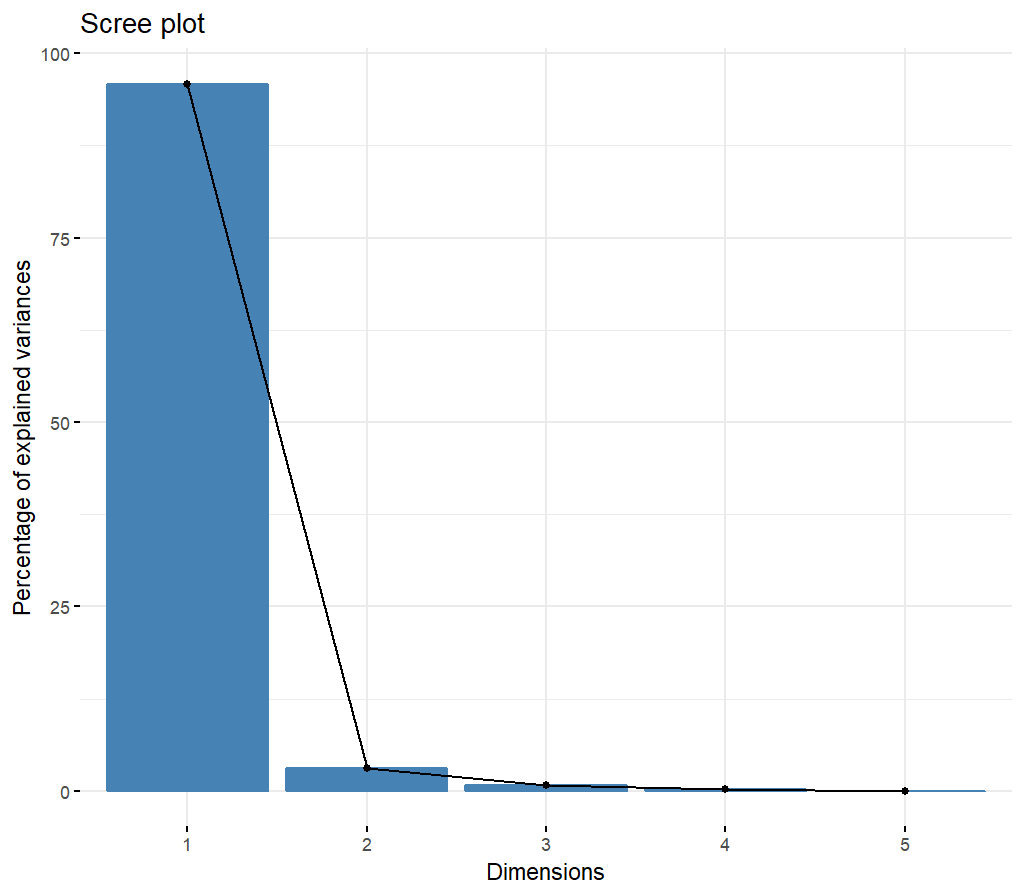

In [779]:
render('pr', plot='varplot')

In [780]:
print(r('summary(pr)'))

Importance of components:

                          PC1    PC2     PC3     PC4     PC5

Standard deviation     2.1894 0.3962 0.18931 0.11341 0.02872

Proportion of Variance 0.9587 0.0314 0.00717 0.00257 0.00016

Cumulative Proportion  0.9587 0.9901 0.99726 0.99984 1.00000



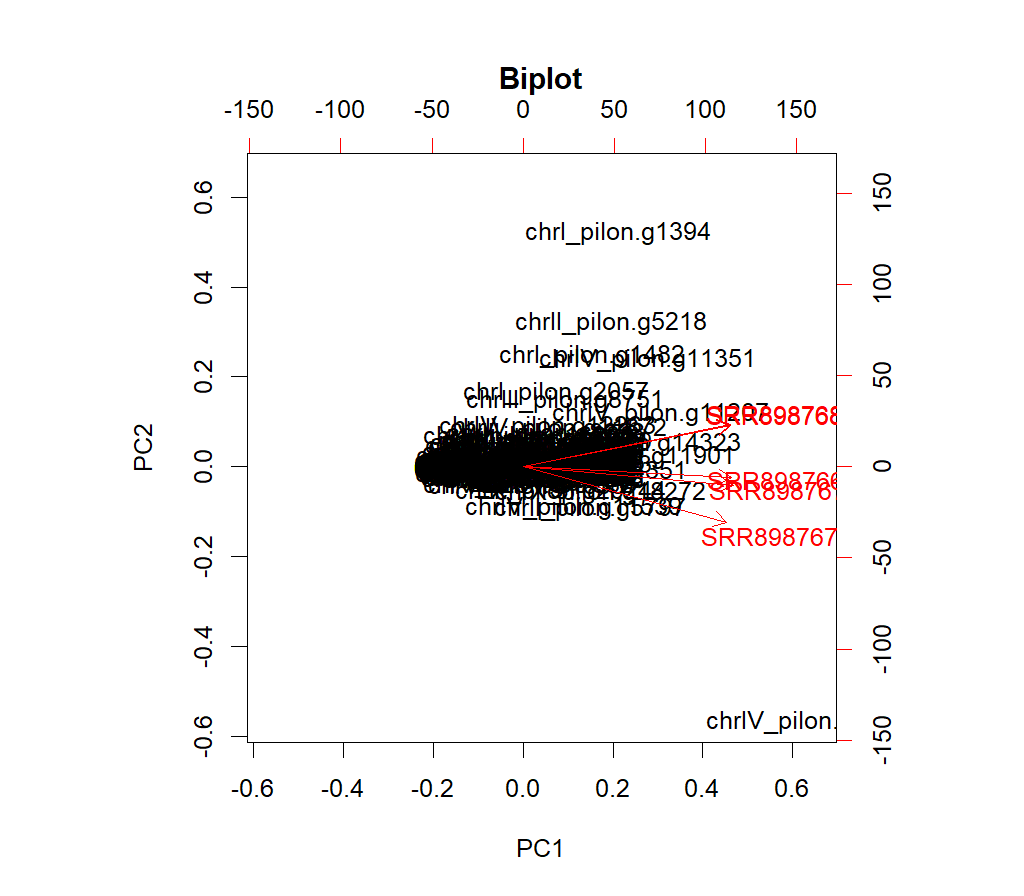

In [781]:
render(r('pr'), plot='biplot')

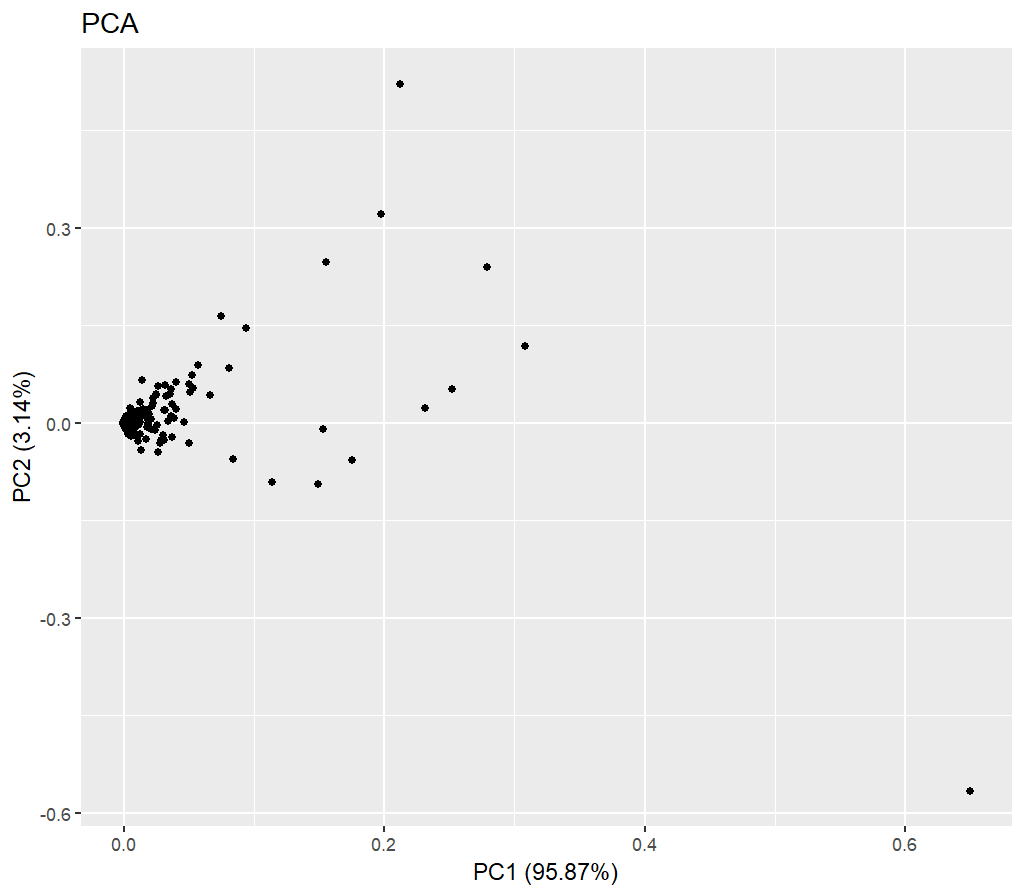

In [782]:
render('pr', plot='auto')

In [783]:
r('dev.off()'); # De ; is belangrijk zodat hij geen extra output cell geeft